In [1]:
#Estudo de caso 5 do curso de Introduação à Ciência de Dados Aplicada à Cibersegurança

#Importando bibliotecas básicas

import numpy as np # vetores e matrizes 
import pandas as pd # processamento dos dados, arquivo CSV I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Importando a base de dados para o pandas

sms = pd.read_csv(r'Downloads\spam.csv', encoding = "ISO-8859-1", usecols=[0,1], skiprows=1,
                  names=["label", "message"])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
sms.label = sms.label.map({"ham":0, "spam":1})

In [4]:
# mais casos negativos (ham) que positivos (spams) 
sms.label.value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [5]:
#Dividindo a base em treino e teste
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(sms.message, 
                                                                            sms.label, 
                                                                            test_size=0.2)

In [6]:
# Criando o documento de treino

from sklearn.feature_extraction.text import CountVectorizer

couvec = CountVectorizer()
couvec.fit(features_train)

CountVectorizer()

In [7]:
# Antes: trained_features = couvec.get_feature_names()
# Depois: 
trained_features = couvec.get_feature_names_out()
print("Número de características vetorizadas:", len(trained_features))
print("Exemplos de características treinadas:", trained_features[1:10])

Número de características vetorizadas: 7696
Exemplos de características treinadas: ['000' '000pes' '008704050406' '0089' '0121' '01223585236' '01223585334'
 '0125698789' '02']


In [8]:
# tokenized train documents

dtm_train = couvec.fit_transform(features_train)
print("Shape of dtm_train:", dtm_train.shape)
print(dtm_train[0:2]) # first two rows of sparse matrix

Shape of dtm_train: (4457, 7696)
  (0, 3063)	1
  (0, 1211)	1
  (0, 2546)	1
  (0, 3756)	1
  (0, 1488)	1
  (0, 3301)	1
  (0, 7417)	1
  (0, 1767)	1
  (1, 6751)	1
  (1, 2682)	1
  (1, 3843)	1
  (1, 3273)	1
  (1, 6864)	1
  (1, 2423)	1
  (1, 2880)	1
  (1, 3779)	1


In [9]:
# tokenized test documents

dtm_test = couvec.transform(features_test)
print("Shape of dtm_test:", dtm_test.shape)

Shape of dtm_test: (1115, 7696)


In [10]:
# Construíndo e avaliando o modelo 

# Multimodal Naive Bayes 
# O classificador multimodal Naive Bays é útil para classificar características discretas. 
# (e.g., número de palavras para classificação de textos). 
# A distribuição multimodal requer geralmente contadores inteiros como features.

# Importando e instanciando o modelo Nayve Bayes Multimodal
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
nb = MultinomialNB()
clf = RandomForestClassifier(random_state=0)

In [11]:
# Treinando o modelo

nb.fit(dtm_train, labels_train)
clf.fit(dtm_train, labels_train)

RandomForestClassifier(random_state=0)

In [12]:
# Fazendo predições

labels_pred = nb.predict(dtm_test)
labels_pred_rf = clf.predict(dtm_test)

In [13]:
# Acurácia
from sklearn import metrics
print("Naive Bayes:", metrics.accuracy_score(labels_test, labels_pred))
print("Random Forest:", metrics.accuracy_score(labels_test, labels_pred_rf))

Naive Bayes: 0.9820627802690582
Random Forest: 0.968609865470852


In [14]:
# Criando a matrix de confusão para precisão e recall (essas são duas outrss métricas de avaliação) 
metrics.confusion_matrix(labels_test, labels_pred)

array([[946,   7],
       [ 13, 149]], dtype=int64)

In [15]:
print("Naive Bayes:")
# Percentagem do total de spams detectados i.e.recall
print("\tRecall:", metrics.recall_score(labels_test, labels_pred))

# Percentagem das predições positivas (spams) corretas, i.e. precisão
print("\tPrecisão:", metrics.precision_score(labels_test, labels_pred))

print("Random Forest:")
# Percentagem do total de spams detectados i.e.recall
print("\tRecall:", metrics.recall_score(labels_test, labels_pred_rf))

# Percentagem das predições positivas (spams) corretas, i.e. precisão
print("\tPrecisão:", metrics.precision_score(labels_test, labels_pred_rf))

Naive Bayes:
	Recall: 0.9197530864197531
	Precisão: 0.9551282051282052
Random Forest:
	Recall: 0.7839506172839507
	Precisão: 1.0


In [16]:
print("Naive Bayes:")
print("\tOrdem das classes no predict_proba:", nb.classes_)
print("\tExemplos de probabilidades de classes:", nb.predict_proba(dtm_test)[0])

print("Random Forest:")
print("\tOrdem das classes no predict_proba:", clf.classes_)
print("\tExemplos de probabilidades de classes:", clf.predict_proba(dtm_test)[0])

Naive Bayes:
	Ordem das classes no predict_proba: [0 1]
	Exemplos de probabilidades de classes: [9.99972054e-01 2.79460211e-05]
Random Forest:
	Ordem das classes no predict_proba: [0 1]
	Exemplos de probabilidades de classes: [1. 0.]


In [17]:
# Uma vez que somente ~15% dos rótulos são positivos (spam), a curva precisão-recall é mais informativa que
# a curva ROC

labels_prob = nb.predict_proba(dtm_test)[:, 1]
precisions, recalls, thresholds = metrics.precision_recall_curve(labels_test, labels_prob)

labels_prob_rf = clf.predict_proba(dtm_test)[:, 1]
precisions_rf, recalls_rf, thresholds_rf = metrics.precision_recall_curve(labels_test, labels_prob_rf)

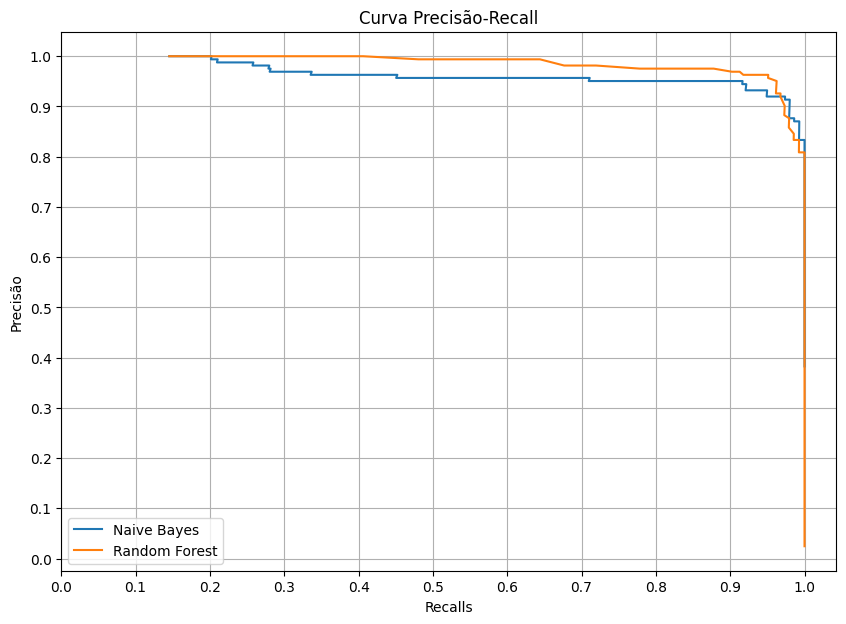

In [18]:
# Plotando a curva precisão-recall 

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1], label="Naive Bayes")
plt.plot(precisions_rf[:-1], recalls_rf[:-1], label="Random Forest")
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisão")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Curva Precisão-Recall")
plt.legend()
plt.grid(.5)
plt.show()